In [1]:
import os
import requests
import urllib
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import asyncio
from data_quality_utils import Crawler
from sentence_transformers import SentenceTransformer, utilfrom typing import List, Optional, Union
from statistics import mode
from crawl4ai import AsyncWebCrawler, CrawlerRunConfig, CacheMode
from crawl4ai.deep_crawling import BFSDeepCrawlStrategy, BestFirstCrawlingStrategy
from crawl4ai.content_scraping_strategy import LXMLWebScrapingStrategy
from crawl4ai.deep_crawling.scorers import KeywordRelevanceScorer
from crawl4ai.deep_crawling.filters import FilterChain, URLPatternFilter, ContentRelevanceFilter, SEOFilter, ContentTypeFilter
from crawl4ai.markdown_generation_strategy import DefaultMarkdownGenerator
from crawl4ai.content_filter_strategy import BM25ContentFilter
from sentence_transformers import SentenceTransformer, util
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [2]:
# embedding model
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# suppress warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# get data from datasette
datasette_base_url = "https://datasette.planning.data.gov.uk/digital-land.csv"

query = """
select * 
from source as s
left join organisation as o
on s.organisation=o.organisation 
where s.collection = "conservation-area"
"""
encoded_query = urllib.parse.urlencode({"sql": query})

r = requests.get(f"{datasette_base_url}?{encoded_query}", auth=('user', 'pass'))

filename = "datasette_data.csv"
with open(filename, "wb") as f_out:
    f_out.write(r.content)

In [4]:
# group by organisation as we're looking for one page per council
data = (
    pl.read_csv(filename)
    .group_by("name")
    .agg(pl.col("website").first(), pl.col("documentation_url"))
)
data = data.with_columns(pl.col("website").str.strip_chars_end("/"))
data

name,website,documentation_url
str,str,list[str]
"""North East Lincolnshire Counci…","""https://www.nelincs.gov.uk""",[null]
"""Blackpool Borough Council""","""https://www.blackpool.gov.uk""",[null]
"""West Berkshire Council""","""https://www.westberks.gov.uk""","[null, ""https://www.westberks.gov.uk/planning-data-conservation-areas""]"
"""Tendring District Council""","""https://www.tendringdc.gov.uk""",[null]
"""St Helens Council""","""https://www.sthelens.gov.uk""","[""https://data.gov.uk/dataset/86bea27d-e174-4a67-aa4b-ee1d3c72a0e8/st-helens-conservation-areas""]"
…,…,…
"""Test Valley Borough Council""","""https://www.testvalley.gov.uk""",[null]
"""Spelthorne Borough Council""","""https://www.spelthorne.gov.uk""",[null]
"""East Suffolk Council""","""https://www.eastsuffolk.gov.uk""","[null, null]"


In [5]:
def get_similar_urls(crawl_data, prompt, num_results=None, chunking=False):
    """
    Embeds crawled webpage data, computes similarity to a given prompt, and returns the top N most similar pages.

    Parameters:
    - crawl_data (list of tuples): A list of tuples containing (url, markdown) for each crawled page.
    - prompt (str): The text prompt to compare against the crawled page embeddings.
    - num_results (int, optional): The number of top similar pages to return. If None, returns all pages.
    - chunking (bool, optional): Whether we want to embed the full webpage or chunk.

    Returns:
    - polars.DataFrame: A DataFrame containing:
        - "url": The webpage URL.
        - "markdown": The extracted markdown content.
        - "embedding": The computed embedding for the content.
        - "similarity": The cosine similarity score with the prompt.
    """
    res = []
    
    if chunking:
        crawl_df = chunk_processing(crawl_data)
    elif not chunking:
        crawl_df = basic_processing(crawl_data)
    
    embeddings = np.stack(crawl_df["embedding"].to_list())
    
    prompt_embedding = np.array(embedding_model.encode(prompt, convert_to_numpy=True), dtype='float64')
    
    # get similarity scores
    sim=util.cos_sim(
        prompt_embedding.astype(np.float32), 
        embeddings.astype(np.float32)
    )
    # get indices of top n most similar urls
    if not num_results:
        num_results = len(crawl_df)
    indices = np.argsort(sim).numpy().flatten()[:-num_results-1:-1]
    sorted_df = (
        crawl_df[indices]
        .with_columns(similarity=np.sort(sim).flatten()[:-num_results-1:-1])
    )
    return sorted_df

In [6]:
def pretty_print_results(sorted_df, num_results):
    # print top n urls with similarity scores
    print("\nTop Similar Pages:\n" + "="*40)
    for i in range(min(num_results, len(sorted_df))):
        url = sorted_df.get_column("url")[i]
        score = sorted_df.get_column("similarity")[i]
        print(f"{i+1}. {url.ljust(60)} | Similarity: {score:.4f}")

In [11]:
def load_csv_data(file_path):
  pl.Config.set_float_precision(10)
  #To give some more readiability, regardless of what is shown the numbers ARE the same!
  df = pl.read_csv(file_path)
  cleaned_df = df.with_columns(
      pl.col("embedding")
        .str.strip_chars("[]")
        .str.replace_all("\n", '')
        .str.strip_chars(" ")
        .str.split(' ')
        .list.eval(pl.element().filter(pl.element() != ""))
        .list.eval(pl.element().cast(pl.Float64, strict=False))
  )
  return cleaned_df

In [12]:
async def process_council(
    council_names,
    max_depth=6,
    keyword_scorer=None,
    filters=None,
    prompt="A page about conservation areas.",
    cache_enabled=False,
    num_results=10,
    save_dfs = False,
    load_dfs = False,
    data_dir = '',
    chunking = False
):
    crawler = Crawler(
            max_depth=max_depth,
            keyword_scorer=keyword_scorer,
            filters=filters,
            cache_enabled=cache_enabled,
        )
    
    crawled_dfs = dict()

    for council_name in council_names:
        council_data = data.filter(pl.col("name").str.contains(council_name))
        short_council_name = council_data.get_column("website")[0].split('.')[1]
        full_name = council_data.get_column("name")[0]
        homepage = council_data.get_column("website")[0]
        prompt = prompt.format((full_name).replace('\n', ''))
        save_path = f"{data_dir}{short_council_name}.csv"

        print("="*40 + f"\nProcessing {full_name}...\n")
        
        if os.path.isdir(data_dir) and load_dfs:
            if f"{short_council_name}.csv" in os.listdir(data_dir): 
                sorted_df = load_csv_data(save_path)
                pretty_print_results(sorted_df, num_results)
                crawled_dfs[homepage] = sorted_df
                continue
            
        # crawl url
        crawl_data = await crawler.deep_crawl(homepage)
        
        # get markdown embeddings
        sorted_df = get_similar_urls(crawl_data, prompt, chunking=chunking)
        sorted_df = sorted_df.with_columns(pl.col("url").str.strip_chars_end("/"))

        
        pretty_print_results(sorted_df, num_results)

        if save_dfs:
            save_df = sorted_df.to_pandas()
            short_council_name = council_data.get_column("website")[0].split('.')[1]
            save_df.to_csv(save_path)

        crawled_dfs[homepage] = sorted_df
    
    return crawled_dfs

## Our approach

Our approach involves 2 main steps: a web crawler and an embedding similarity search. Below is a description of these steps.

### Web crawler

The web crawler takes a homepage URL of an organisation (council website) and crawls it to look for pages talking about conservation areas.

The crawler will look for links on a single page, put them in a queue and then iteratively check them until it finds what it was looking for or it reaches a stopping criterion, such as maximum depth (how many clicks away from home page). 

In order to save time, we can define some scorers or filters which tell the crawler which pages to prioritise or ignore. In this case, some common patterns of what a user needs to click to get to the page of interest are _"planning"_, _"building"_, _"heritage"_ or _"conservation"_.

The crawler uses a *"best first strategy"*, which utilises the scorers or filters to visit most relevant sites first, rather than a depth-first or breath-first search.

The crawler extracts the HTML from the pages and turns them into markdown. This is because it's more readable and easier to work with in the next steps. The crawler returns a list of pairs of (_url_, _markdown_).

### Embedding search

To be filled

### The next few cells show how to use the tools to find conservation area pages.

You can define your own parameters, such as maximum depth, how many results you want to see and any scorers or filters. Below is a template showing how to defin each scorer/filter type correctly - all you need to do is change the keywords or patterns.

You can also define a prompt - this is what will be used to get embeddings scores for a webpage. The more similar the prompt is to what a conservation area page usually looks like, the more accurate the results.

Lastly, you can await the `process_council` function, which will run the functionality described above and print the results. You can use it for one council only or for a list of councils.

#### Template for how to define filters or scorers
##### Pick the types you need and adjust their parameter (keywords, threshold, ...) and pass them to the crawler function.
    keyword_scorer = {
        "keywords": ["conservation", "conservation area", "planning", "building", "urban", "heritage", "resident"],
        "weight": 0.8,
    }
        
    filters=[
        {"type": "SEOFilter", "threshold": 0.6, "keywords": ["conservation", "area", "planning", "heritage", "resident"]},
        {"type": "ContentRelevanceFilter", "query": "conservation area or planning data", "threshold": 0.2},
        {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
        {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
    ]

### Gedling

In [8]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

df = await process_council(
    council_names=["Gedling"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing Gedling Borough Council...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 137 pages in total

Top Similar Pages:
1. https://www.gedling.gov.uk/conservation/#page                | Similarity: 0.6600
2. https://www.gedling.gov.uk/conservation/                     | Similarity: 0.6600
3. http://www.gedling.gov.uk/resident/planningandbuildingcontrol/ | Similarity: 0.6419
4. http://www.gedling.gov.uk/resident/planningandbuildingcontrol/#page | Similarity: 0.6419
5. https://www.gedling.gov.uk/resident/planningandbuildingcontrol/ | Similarity: 0.6416
6. https://www.gedling.gov.uk/resident/planningandbuildingcontrol/#page | Similarity: 0.6416
7. https://www.gedling.gov.uk/resident/planningandbuildingcontrol/planningpolicy/naturalenvironment/ | Similarity: 0.6250
8. https://www.gedling.gov.uk/resident/planningandbuildingcontrol/planningpolicy/naturalenvironment/#page | Similarity: 0.6250
9. http://www.gedling.gov.uk/resident/planningandbuildingcontrol/planningpolicy/ | Similarity: 0.6018

CancelledError: 

### South Gloucestershire

In [8]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["South Gloucestershire"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing South Gloucestershire Council...

[INIT].... → Crawl4AI 0.5.0.post4


### Bournemouth, Christchurch and Poole

In [13]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["Bournemouth, Christchurch and Poole"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing Bournemouth, Christchurch and Poole Council...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 504 pages in total

Top Similar Pages:
1. https://www.bcpcouncil.gov.uk/planning-and-building-control/urban-design-trees-and-conservation/conservation-areas | Similarity: 0.6143
2. https://www.bcpcouncil.gov.uk/planning-and-building-control/urban-design-trees-and-conservation/conservation-areas#guide-contents | Similarity: 0.6143
3. https://www.bcpcouncil.gov.uk/planning-and-building-control/urban-design-trees-and-conservation/conservation-areas#main | Similarity: 0.6143
4. https://bcpcouncil.gov.uk/planning-and-building-control/local-land-charges | Similarity: 0.6074
5. https://bcpcouncil.gov.uk/planning-and-building-control/local-land-charges#guide-contents | Similarity: 0.6074
6. https://bcpcouncil.gov.uk/planning-and-building-control/local-land-charges#main | Similarity: 0.6074
7. https://bcpcouncil.gov.uk/planning-and-building-control/urban-design-trees-and-conservation/listed-buil

### Warrington

In [9]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["Warrington"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing Warrington Borough Council...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 67 pages in total

Top Similar Pages:
1. https://www.warrington.gov.uk/nature-conservation#main-content | Similarity: 0.6056
2. https://www.warrington.gov.uk/nature-conservation            | Similarity: 0.6056
3. https://online.warrington.gov.uk/planning/index.html         | Similarity: 0.5629
4. https://online.warrington.gov.uk/planning/                   | Similarity: 0.5513
5. https://www.warrington.gov.uk/supplementary-planning-documents-consultation | Similarity: 0.5456
6. https://www.warrington.gov.uk/supplementary-planning-documents-consultation#main-content | Similarity: 0.5456
7. https://www.warrington.gov.uk/supplementary-planning-documents | Similarity: 0.5359
8. https://www.warrington.gov.uk/supplementary-planning-documents#main-content | Similarity: 0.5359
9. https://www.warrington.gov.uk/planning-policy-archives#main-content | Similarity: 0.5312
10. https://www.warrington.gov.uk/planning-p

### Stoke on Trent

In [10]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["Stoke"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing Stoke-on-Trent City Council...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 129 pages in total

Top Similar Pages:
1. https://www.stoke.gov.uk/info/20005/planning_and_building/547/conservation_areas#content | Similarity: 0.8232
2. https://www.stoke.gov.uk/info/20005/planning_and_building/547/conservation_areas | Similarity: 0.8232
3. https://www.stoke.gov.uk/news/article/1509/council_announces_new_conservation_areas#content | Similarity: 0.8073
4. https://www.stoke.gov.uk/news/article/1509/council_announces_new_conservation_areas | Similarity: 0.8073
5. https://www.stoke.gov.uk/news/article/1285/changes_to_conservation_areas_in_stoke-on-trent | Similarity: 0.7924
6. https://www.stoke.gov.uk/news/article/1285/changes_to_conservation_areas_in_stoke-on-trent#content | Similarity: 0.7924
7. https://www.stoke.gov.uk/conservationareas#content           | Similarity: 0.7902
8. http://www.stoke.gov.uk/conservationareas                    | Similarity: 0.7902
9. https://www.stoke.gov.u

### Redbridge

In [14]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["Redbridge"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing London Borough of Redbridge...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 762 pages in total

Top Similar Pages:
1. https://www.redbridge.gov.uk/planning-and-building/protected-buildings-and-conservation-areas/article-4-direction-c4-hmos/ | Similarity: 0.6607
2. https://www.redbridge.gov.uk/planning-and-building/protected-buildings-and-conservation-areas/article-4-direction-c4-hmos/#accessibilitySkip | Similarity: 0.6607
3. https://www.redbridge.gov.uk/planning-and-building/protected-buildings-and-conservation-areas/ | Similarity: 0.6513
4. https://www.redbridge.gov.uk/planning-and-building/protected-buildings-and-conservation-areas/#accessibilitySkip | Similarity: 0.6513
5. https://www.redbridge.gov.uk/Account/Register?returnurl=%2Fplanning-and-building%2Fprotected-buildings-and-conservation-areas%2Farticle-4-direction-c4-hmos%2F&clientid=RedbridgeCMSLive#accessibilitySkip | Similarity: 0.6512
6. https://www.redbridge.gov.uk/Account/Register?returnurl=%2Fplanning-and-buildi

### York

In [25]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": [r"*[Cc]onservation*", r"*[Pp]lanning*", r"*[Bb]uilding*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["York"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing York...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 3260 pages in total

Top Similar Pages:
1. https://planningaccess.york.gov.uk/online-applications/#top  | Similarity: 0.4857
2. https://planningaccess.york.gov.uk/online-applications/#pageheading | Similarity: 0.4857
3. https://planningaccess.york.gov.uk/online-applications/      | Similarity: 0.4857
4. https://www.york.gov.uk/conservation-listed-buildings/york-central-historic-core-conservation-area-appraisal-hccaa#content | Similarity: 0.4832
5. https://www.york.gov.uk/conservation-listed-buildings/york-central-historic-core-conservation-area-appraisal-hccaa | Similarity: 0.4832
6. https://www.york.gov.uk/conservation-listed-buildings/york-central-historic-core-conservation-area-appraisal-hccaa#js-menu | Similarity: 0.4832
7. https://www.york.gov.uk/conservation-listed-buildings/york-central-historic-core-conservation-area-appraisal-hccaa#top | Similarity: 0.4832
8. https://www.york.gov.uk/conservation-listed-buildings/yor

### Malvern Hills

In [ ]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": [r"*[Cc]onservation*", r"*[Pp]lanning*", r"*[Bb]uilding*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=["Malvern Hills"], 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

Processing Malvern Hills...

[INIT].... → Crawl4AI 0.5.0.post4


## Multiple councils

You can define any list of councils and their processing will be executed sequentially

In [29]:
np.random.seed(4321)
num_examples = 10
example_idx = np.random.randint(0, len(data), num_examples)
examples = data[example_idx]
examples

name,website,documentation_url
str,str,list[str]
"""Canterbury City Council""","""https://www.canterbury.gov.uk""","[""https://mapping.canterbury.gov.uk/arcgis/rest/services/External/Planning_Constraints_New/MapServer""]"
"""Leicester City Council""","""https://www.leicester.gov.uk""","[""https://data.gov.uk/dataset/e702ebff-27b4-4e86-acbb-74d066f3c4e7/conservation-areas"", ""https://data.leicester.gov.uk/explore/?q=conservation+area&sort=modified"", ""https://data.leicester.gov.uk/explore/?q=conservation+area&sort=modified""]"
"""Gateshead Metropolitan Borough…","""https://www.gateshead.gov.uk""","[null, ""https://gateshead-council-open-data-gateshead.hub.arcgis.com/datasets/Gateshead::spe-hx-conservation-areas/about""]"
"""Runnymede Borough Council""","""https://www.runnymede.gov.uk""",[null]
"""Birmingham City Council""","""https://www.birmingham.gov.uk""","[null, null, … ""https://openplanningdata-sbham.hub.arcgis.com/datasets/ee06653284154ccfb4fec1e9428760e1/about""]"
"""Thurrock Thames Gateway Develo…","""https://www.gov.uk/government/…",[null]
"""Basildon Borough Council""","""https://www.basildon.gov.uk""",[null]
"""London Borough of Richmond upo…","""https://www.richmond.gov.uk""",[null]
"""Ministry of Housing, Communiti…","""https://www.gov.uk/government/…","[""https://dluhc-datasets.planning-data.dev/dataset/conservation-area-document-type"", ""https://github.com/digital-land/conservation-area-data/tree/main/data/Output/Missing"", … ""https://dataset-editor.development.planning.data.gov.uk/dataset/conservation-area-document-type""]"


In [ ]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
The text discusses conservation areas from the {} and includes data on 
planning data, areas, interactive maps, appraisals, notices, boundaries, 
links and similar.
"""

await process_council(
    council_names=examples.get_column("name"), 
    max_depth=max_depth, 
    filters=filters, 
    prompt=prompt, 
    num_results=num_results
)

## Evaluating Results

For this section we manually labelled 25 councils with their true page. We perform tests and ranking here to assess the performance of our model.

In [13]:
test_df = pl.read_csv("data/page_ranking_truth_df.csv")
test_df = test_df.with_columns(pl.col("correct_documentation_url").str.strip_chars_end("/"))
test_website_list = test_df["website"].to_list()
data_filtered = data.filter(pl.col("website").is_in(test_website_list))
combined_df = data_filtered.join(test_df, on='website')

In [ ]:
max_depth = 6
num_results = 10
filters=[
    {"type": "ContentTypeFilter", "allowed_types": ["text/html"]},
    {"type": "URLPatternFilter", "patterns": ["*conservation*", "*planning*", "*building*"]},
]

# please write the prompt such that there is a curly bracket where the council
# name will be inserted
prompt = """
Conservation Areas in {}

We are committed to preserving the historic and architectural character of our borough
through designated conservation areas. These areas protect buildings, streets, and 
landscapes of special significance, ensuring that any changes respect their unique heritage. 
If you live or own property in a conservation area, additional planning controls may 
apply to alterations, demolitions, and new developments. Our aim is to balance modern 
needs with the protection of our historic environment. For more information on conservation 
area guidelines, planning applications, and how you can contribute to local heritage preservation, 
please visit our planning and conservation pages.
"""
# Fair warning, this will take multiple hours to run in its entirety. 
# You can save and reload with the provided arguments, but the csvs are very large.

test_output_dict = await process_council(
    council_names=combined_df.get_column("name")[:5], # Just the first 5 takes 20 mins.
    max_depth=max_depth, 
    filters=filters,        
    prompt=prompt, 
    num_results=num_results,
    save_dfs = False,
    load_dfs = False,
    data_dir = 'chunking_test_dfs/',
    chunking = True
)

Processing Gloucester City Council...

[INIT].... → Crawl4AI 0.5.0.post4
Crawled 212 pages in total

Top Similar Pages:
1. https://www.gloucester.gov.uk/planning-development/conservation-regeneration/conservation-regeneration-faqs/#main-content | Similarity: 0.8453
2. https://www.gloucester.gov.uk/planning-development/conservation-regeneration/conservation-regeneration-faqs | Similarity: 0.8453
3. https://www.gloucester.gov.uk/planning-development/conservation-regeneration/conservation-areas | Similarity: 0.8303
4. https://www.gloucester.gov.uk/planning-development/conservation-regeneration/conservation-areas/#main-content | Similarity: 0.8303
5. https://www.gloucester.gov.uk/planning-development/planning-applications/planning-applications-faqs | Similarity: 0.8252
6. https://www.gloucester.gov.uk/planning-development/planning-applications/planning-applications-faqs/#main-content | Similarity: 0.8252
7. https://www.gloucester.gov.uk/planning-development/planning-applications/planning-a

In [23]:
def url_cleaning(df, col):
    df = df.with_columns(pl.col(col).str.replace(
        "http://", "https://", literal=True))
    df = df.with_columns(pl.col(col).str.replace(
        "www.", "", literal=True))
    df = df.with_columns(pl.col(col).str.strip_chars_end("/"))
    return df

In [24]:
def df_cleaning(df):
    df = url_cleaning(df, 'url')
    df = url_cleaning(df, 'id')
    df = df.sort(by = 'similarity', descending=True)
    return df

In [25]:
def get_result_rank(correct_webpage, df):
    similarity_scores = list(set(df['similarity']))
    sorted_similarity_scores = sorted(similarity_scores, reverse=True)
    result_rows = df.filter(pl.col('url') == correct_webpage)
    best_similarity_score = result_rows['similarity'][0]

    rank = sorted_similarity_scores.index(best_similarity_score) + 1
    print(f'rank is {rank} with similarity {best_similarity_score}')
    return rank

In [26]:
def test_ranking_processing(test_df: pl.dataframe.frame.DataFrame, test_output_dict: dict, outlier_threshold: int = 1000):
    """Processing to analyse the ranking of our pipeline's embedding guesses. 

    :param test_df: polars.DataFrame with columns:
        - "website": The base website of the council
        - "correct_documentation_url": The manually judged correct webpage. This should have the largest embedding similarity.
    :param test_output_dict: dictionary with outputs of webscraping and embedding. Keys are base websites and values are dataframes.
    :param outlier_threshold: Threshold for ranks beyond which results are assumed false/failure. If above, not saved in ranking_dict.
    :return: 
        ranking_dict: Dictionary with ranks for each website. Base websites are keys, ranks are values
        num_unclassified: Quantity of failed experiments, where no website match could be found.
        num_outliers: Quantity of experiments leading to outliers.
    """
    
    ranking_dict = dict()
    filtered_output_dict = {url: df_cleaning(df)
                        for url, df in test_output_dict.items()}
    
    num_unclassified = 0
    num_outliers = 0

    for base_website, similarity_df in filtered_output_dict.items():
        print(f'processing {base_website}')
        correct_webpage = test_df.filter(pl.col('website') == base_website)['correct_documentation_url'][0]
        try:
            rank = get_result_rank(correct_webpage, similarity_df)
            if rank >= outlier_threshold:
                print(f"Outlier for this url - rank of {rank} - leaving out of plot")
                num_outliers += 1
                break
            ranking_dict[base_website] = rank
        
        except IndexError as e:
            print(f"No match for correct website via urls - error message '{e}'")
            num_unclassified += 1 
                
    return ranking_dict, num_unclassified, num_outliers

In [27]:
test_df = url_cleaning(test_df, 'correct_documentation_url')
ranking_dict, num_unclassified, num_outliers = test_ranking_processing(test_df, 
                                                                       test_output_dict, 
                                                                       outlier_threshold=30)

processing https://www.gloucester.gov.uk
rank is 2 with similarity 0.8302638530731201
processing https://www.great-yarmouth.gov.uk
rank is 1 with similarity 0.7118769288063049
processing https://www.southglos.gov.uk
rank is 1 with similarity 0.7504985332489014
processing https://www.epsom-ewell.gov.uk
rank is 1 with similarity 0.695812463760376
processing https://www.westberks.gov.uk
rank is 2 with similarity 0.6313367486000061


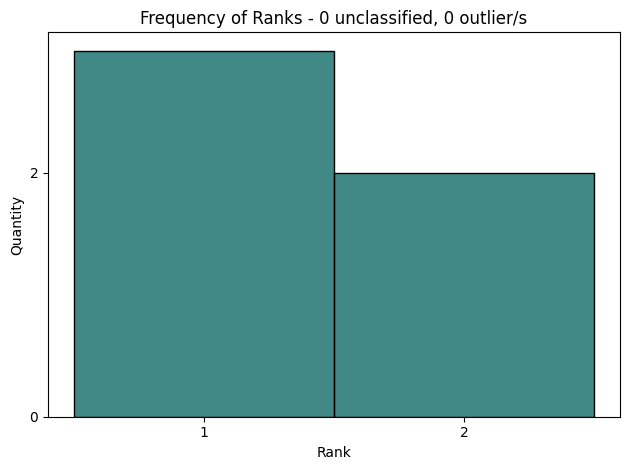

In [28]:
ranks = list(ranking_dict.values())
height = ranks.count(mode(ranks))

ax = sns.histplot(x=ranks, binwidth=1, discrete=True, color='#00625E')
ax.set_title(f'Frequency of Ranks - {num_unclassified} unclassified, {num_outliers} outlier/s')
ax.set_xlabel('Rank')
ax.set_ylabel('Quantity')
ax.set_xticks(np.arange(1, max(ranks)+1))
ax.set_yticks(np.arange(0, height+1, 2))
ax.set_xticklabels([str(num) for num in np.arange(1, max(ranks)+1)])
ax.set_yticklabels([str(num) for num in np.arange(0, height+1, 2)])

plt.tight_layout()
plt.show()

In [29]:
def mean_reciprocal_rank(ranks):
    size = len(ranks)
    return sum([1/rank for rank in ranks])/size

In [30]:
mrr = mean_reciprocal_rank(ranks)
print(f"Mean Reciprocal Rank of - {mrr}")

Mean Reciprocal Rank of - 0.8
